# Sentiment Analysis with Bi-directional LSTM

In this tutorial we will carry out Sentiment Analysis on 1,600,000 tweets extracted using the Twitter API . The tweets have been annotated as 0 = negative and 4 = positive. For additional information on the dataset please visit following [link](http://help.sentiment140.com/home)

In [ ]:
%tensorflow_version 1.x

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import tensorflow as tf

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
from wordcloud import WordCloud

# print tensorflow version
print(f'Tensorflow version: {tf.__version__}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Tensorflow version: 1.15.2


In [ ]:
# download the dataset
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2020-06-28 03:00:46--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  39.8MB/s    in 1.9s    

2020-06-28 03:00:48 (39.8 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [ ]:
# unzip the file
!unzip '/content/trainingandtestdata.zip'

Archive:  /content/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# define column width
pd.set_option('display.max_colwidth',300)

# name the columns and define encoding to be used for reading the data
df_columns = ["sentiment", "ids", "date", "query", "user", "text"]

twt = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=df_columns)

In [ ]:
# check the data
twt.head()

,sentiment,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
# Drop "ids", "date", "query", "user" columns are they are not required
twt = twt.drop(columns=["ids", "date", "query", "user"])

In [ ]:
# verify if the columns have been dropped
twt.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
# check dataset info
twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
# check total number of unique values
twt['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [ ]:
# check for null values in our data
twt.isnull().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
# map 'Positive' and 'Negative' labels
label_map = {0:'Negative', 4:'Positive'}

def label_decoder(label):
    return label_map[label]

twt['sentiment'] = twt['sentiment'].apply(lambda x: label_decoder(x))
twt.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Text(0.5, 1.0, 'Sentiment Data Distribution')

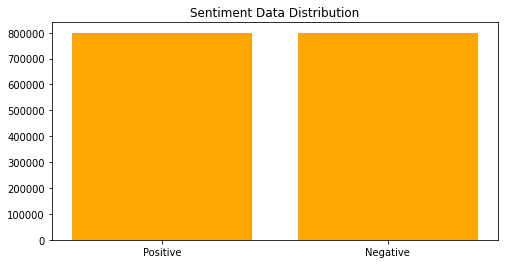

In [ ]:
# check out sentiment distribution
plt.figure(figsize=(8,4))
plt.bar(twt.sentiment.value_counts().index, twt.sentiment.value_counts().values, color='orange')
plt.title("Sentiment Data Distribution")

In [ ]:
# preprocess textual data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', text.lower(), re.UNICODE)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text

twt.text = twt.text.apply(lambda x: preprocess(x))

In [ ]:
# check preprocessed data
twt.text.head(10)

0                              awww bummer shoulda get david carr third day
1    upset update facebook texting might cry result school today also blah 
2                           dive many time ball manage save 50 rest go bind
3                                          whole body feel itchy like fire 
4                                                           behave mad see 
5                                                               whole crew 
6                                                                 need hug 
7                      hey long time see yes rain bite bite lol fine thank 
8                                                                     nope 
9                                                                que muera 
Name: text, dtype: object

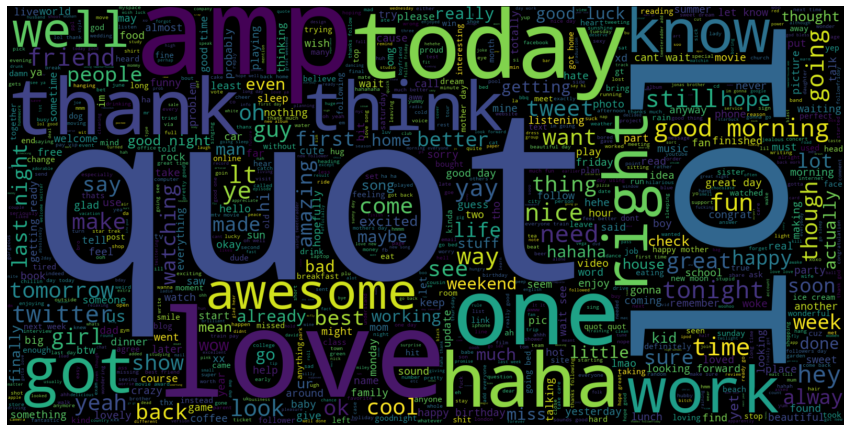

In [ ]:
# word cloud for positive words
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(twt[twt.sentiment == 'Positive'].text))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

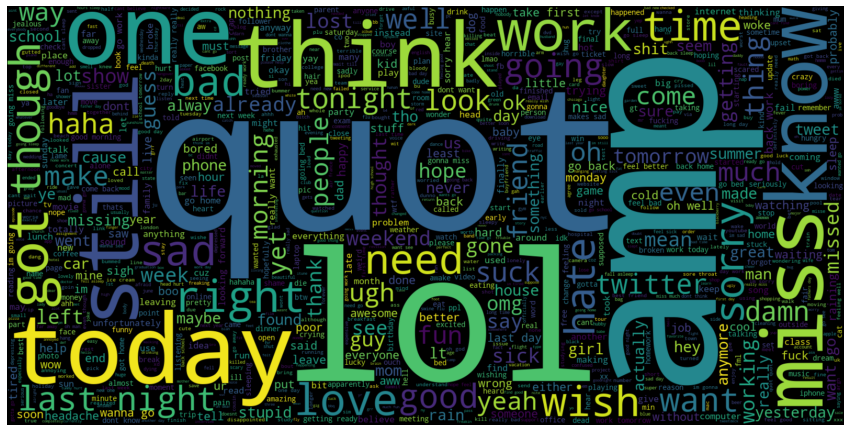

In [ ]:
# word cloud for negative words
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(twt[twt.sentiment == 'Negative'].text))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

In [ ]:
# do train test split
train_data, test_data = train_test_split(twt, test_size=0.2)

print(f'Training Data Size: {len(train_data)}')
print(f'Testing Data Size: {len(test_data)}')

Training Data Size: 1280000
Testing Data Size: 320000


__We did not do 'fit_on_texts' on 'test_docs' as it uses the vocab learned from the training data to index words in test. If there are new words, they are marked as zero.__

In [ ]:
# tokenize the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data.text)

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 271655


In [ ]:
# save tokenizer
def save_tokenizer(tokenizer):
    with open('twitter_tokenizer.pkl', mode='wb') as t:
        dump(tokenizer, t)
        print(f'Saved Tokenizer')

save_tokenizer(tokenizer)

Saved Tokenizer


In [ ]:
# encode training and testing data
train_encoded_data = tokenizer.texts_to_sequences(train_data.text) 
test_encoded_data = tokenizer.texts_to_sequences(test_data.text)

# pad sequences on encoded training and testing data
max_length = max([len(t.split()) for t in train_data.text])
print(f'Maximum length of a Tweet : {max_length}')
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_encoded_data, maxlen=max_length, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_encoded_data, maxlen=max_length, padding='post')

# get shape of the data
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')

Maximum length of a Tweet : 36
X_train Shape: (1280000, 36)
X_test Shape: (320000, 36)


In [ ]:
# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_data.sentiment.to_list())

y_train = label_encoder.transform(train_data.sentiment.to_list())
y_test = label_encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# get shape of labels
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

y_train Shape: (1280000, 1)
y_test Shape: (320000, 1)


In [ ]:
# get Glove Embeddings
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2020-06-28 03:04:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.07MB/s    in 6m 27s  

2020-06-28 03:10:39 (2.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# unzip the file
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# load embedding as a dictionary
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename, mode='r', encoding='utf-8')    
    # create a map of words to vectors
    embedding = dict()
    for line in file:
        values = line.split()
        # key is string word, value is numpy array for vector
        embedding[values[0]] = np.asarray(values[1:], dtype='float32')
    # close the file
    file.close()
    return embedding

# load embedding from file
raw_embeddings = load_embedding('/content/glove.6B.300d.txt')

In [ ]:
# create a weight matrix for the Embedding layer from the loaded embedding
def get_weight_matrix(raw_embeddings, vocab_size, tokenizer, dim):
    # define weight matrix dimensions with all 0s
    weight_matrix = np.zeros((vocab_size, dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in tokenizer.word_index.items():
        vector = raw_embeddings.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

# get vectors in the right order
embedding_matrix = get_weight_matrix(raw_embeddings, vocab_size, tokenizer, dim=300)

In [ ]:
# define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True, dropout=0.4)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout=0.4)))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 300)           81496500  
_________________________________________________________________
bidirectional (Bidirectional (None, 36, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (N

In [ ]:
# define the model
#def define_model(max_length, vocab_size):
#    inputs = tf.keras.layers.Input(shape=(max_length,))
#    embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=200)(inputs)
#    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True, dropout=0.4))(embeddings)
#    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout=0.4))(lstm_1)
#    dense = tf.keras.layers.Dense(units=128, activation='relu')(lstm_2)
#    dropout = tf.keras.layers.Dropout(0.4)(dense)
#    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(dropout)
#    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#    return model

#model = define_model(max_length, vocab_size)

# print model summary
#model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 200)           58175000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 512)           935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129   

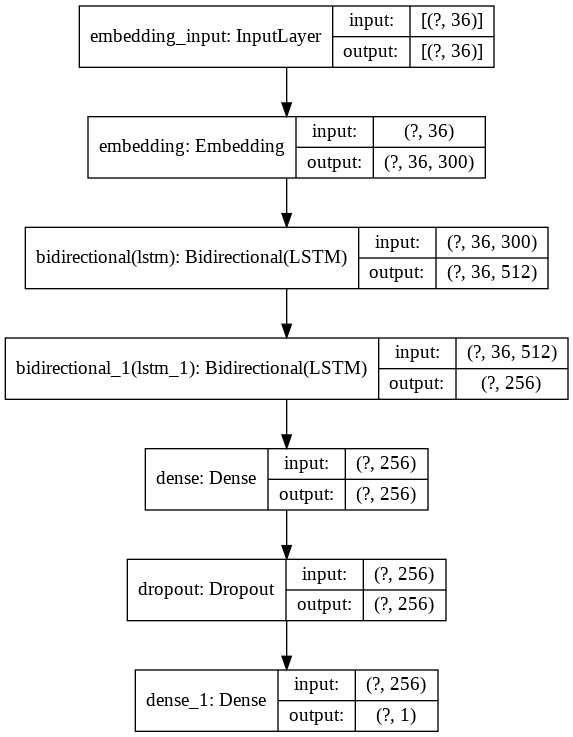

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, to_file='txt_rnn.png', show_shapes=True)

In [ ]:
# compile the network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# define model checkpoint
mckpt = tf.keras.callbacks.ModelCheckpoint('txt_rnn_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# fit the network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=2048, callbacks=[es,mckpt])

Train on 1280000 samples, validate on 320000 samples
Epoch 1/20
1277952/1280000 [============================>.] - ETA: 0s - loss: 0.5255 - acc: 0.7345
Epoch 00001: val_loss improved from inf to 0.48223, saving model to txt_rnn_model.h5
1280000/1280000 [==============================] - 227s 178us/sample - loss: 0.5255 - acc: 0.7345 - val_loss: 0.4822 - val_acc: 0.7657
Epoch 2/20
1277952/1280000 [============================>.] - ETA: 0s - loss: 0.4841 - acc: 0.7647
Epoch 00002: val_loss improved from 0.48223 to 0.46848, saving model to txt_rnn_model.h5
1280000/1280000 [==============================] - 223s 174us/sample - loss: 0.4841 - acc: 0.7647 - val_loss: 0.4685 - val_acc: 0.7754
Epoch 3/20
1277952/1280000 [============================>.] - ETA: 0s - loss: 0.4709 - acc: 0.7731
Epoch 00003: val_loss improved from 0.46848 to 0.45986, saving model to txt_rnn_model.h5
1280000/1280000 [==============================] - 222s 174us/sample - loss: 0.4709 - acc: 0.7731 - val_loss: 0.4599 

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

320000/320000 [==============================] - 476s 1ms/sample - loss: 0.4497 - acc: 0.7906


In [ ]:
# print accuracy on test dataset
print(f'Test Accuracy : {accuracy*100:.2f}')

Test Accuracy : 79.06


In [ ]:
# Plot Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

In [ ]:
# Plot Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

In [ ]:
# Serve model as a flask application
import tensorflow as tf
import joblib

rnn_twt_model = None
tokenizer = None

# load model at the beginning once only
def loadmodel():
    global rnn_twt_model
    rnn_twt_model = tf.keras.models.load_model("txt_rnn_model.h5")
    return rnn_twt_model

loadmodel()

# load tokenizer at the beginning once only
def load_tokenizer():
    global tokenizer
    tokenizer = joblib.load('twitter_tokenizer.pkl')
    return tokenizer

load_tokenizer()

# encode the raw text
def encode_text(tokenizer, raw_text):
    # encode text sequence to integer
    encoded = tokenizer.texts_to_sequences([raw_text])
    # pad encoded sequences
    encoded_text = tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=36, padding='post')
    return encoded_text

#model = tf.keras.models.load_model("multichannel_cnn_txt_model.h5")
#tokenizer = joblib.load('tokenizer.pkl')

def get_sentiment():
	raw_text = str(input('Enter a Tweet : '))
	print(f'Raw Text : {raw_text}')
	encoded_text = encode_text(tokenizer, raw_text)
	print(f'Encoded Text : {encoded_text}')
	prediction = rnn_twt_model.predict(encoded_text)
	print(f'Prediction : {prediction}')
	if float(prediction[0]) >= 0.50:
		return "It's a Positive Tweet"
	else:
		return "It's a Negative Tweet"

get_sentiment()

Enter a Tweet : Disneyland will no longer open on July 17, a new date is to be determined
Raw Text : Disneyland will no longer open on July 17, a new date is to be determined
Encoded Text : [[  2634  89024    641    347  38335    694   1201  30392     34    478
   85710  92965 112284      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0]]
Prediction : [[0.34580874]]


"It's a Negative Tweet"

[Bidirectional LSTM on IMDB](https://keras.io/examples/nlp/bidirectional_lstm_imdb/)

[Text Classification with RNN](https://www.tensorflow.org/tutorials/text/text_classification_rnn)

[Text Classification using LSTM](https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm)

[Best Practices for Text Classification with Deep Learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)
